In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 24 16:35:51 2020

@author: u300737
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr
import scipy.interpolate as scint

start_path=os.getcwd()
ac3_scripts_path=start_path+"/../scripts/"
plot_path=start_path+"/../plots/div_tendency/"
if not os.path.exists(plot_path):
    os.makedirs(plot_path)
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
hamp_processing_path=my_git_path+"/hamp_processing_python/"

synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
retrieval_src_path=my_git_path+"/hamp_retrieval_haloac3/"
config_path=synth_ar_path+"config/"

sys.path.insert(1,config_path)
sys.path.insert(2,ac3_scripts_path)
sys.path.insert(3,synth_ar_path+"src/")
sys.path.insert(4,synth_ar_path+"plotting/")
sys.path.insert(5,hamp_processing_path)
sys.path.insert(6,hamp_processing_path+"plotting/")
sys.path.insert(7,retrieval_src_path+"src/")
sys.path.insert(8,start_path+"/../plotting/")
import data_config
###############################################################################
import flightcampaign
import moisturebudget as Budgets
###############################################################################
#Grid Data
from reanalysis import ERA5,CARRA 
from ICON import ICON_NWP as ICON
import gridonhalo as Grid_on_HALO
###############################################################################
#-----------------------------------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")

import matplotlib

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

from simplified_flight_leg_handling import simplified_run_grid_main


C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
relevant_warm_sector_sondes={}
relevant_warm_sector_sondes["RF05_AR_entire_1_in"]=[0,1,2,3]
relevant_warm_sector_sondes["RF05_AR_entire_1_out"]=[9,10,11,12]
relevant_warm_sector_sondes["RF05_AR_entire_2_out"] = [9,10,11,12]
relevant_warm_sector_sondes["RF05_AR_entire_2_in"]= [15,16,17,18]
relevant_warm_sector_sondes["RF06_AR_entire_1_in"]=[0,1,2]
relevant_warm_sector_sondes["RF06_AR_entire_1_out"]=[8,9,10]
relevant_warm_sector_sondes["RF06_AR_entire_2_in"]=[8,9]
relevant_warm_sector_sondes["RF06_AR_entire_2_out"]=[16,17]

In [3]:
def summarize_sector_div_data(leg_list=["RF05_AR_entire_1","RF05_AR_entire_2",
                                        "RF06_AR_entire_1","RF06_AR_entire_2"],
                              major_work_path=major_work_path,scalar_based_div=True):
    
    sonde_budget_path=major_work_path+"//HALO_AC3/data/budgets/"
    
    tendency_nabla_ivt={}
    tendency_nabla_ivt["adv_q"]={}
    tendency_nabla_ivt["mass_conv"]={}
    tendency_nabla_ivt["sum"]={}
    
    #unc_colors=[,"lightcyan","mintcream","palegoldenrod"]
    Dropsondes_dict={}
    for l,leg in enumerate(leg_list):
        rf=leg.split("_")[0]
        ar_of_day=leg.split("_")[-3]+"_"+leg.split("_")[-2]+"_"+leg.split("_")[-1]
        print(leg)
        with HiddenPrints():
            halo_era5,halo_df,cmpgn_cls,ERA5_on_HALO,radar,Dropsondes_dict[leg]=\
                simplified_run_grid_main(flight=[rf],config_file_path=major_work_path,ar_of_day=ar_of_day)
        if scalar_based_div:
            adv_file_name=rf+"_"+ar_of_day+"_warm_Real_Sondes_"+"adv_q"+".csv"
            mass_file_name=rf+"_"+ar_of_day+"_warm_Real_Sondes_"+"mass_convergence"+".csv"
        else:
            adv_file_name=rf+"_"+ar_of_day+"_warm_Real_Sondes_"+"vector_adv_q"+".csv"
            mass_file_name=rf+"_"+ar_of_day+"_warm_Real_Sondes_"+"vector_mass_convergence"+".csv"
            
        tendency_nabla_ivt["adv_q"][leg]=pd.read_csv(sonde_budget_path+adv_file_name,index_col=0)
        tendency_nabla_ivt["mass_conv"][leg]=pd.read_csv(sonde_budget_path+mass_file_name,index_col=0)
        tendency_nabla_ivt["sum"][leg]=tendency_nabla_ivt["adv_q"][leg]+\
                                        tendency_nabla_ivt["mass_conv"][leg]
    
    return tendency_nabla_ivt,Dropsondes_dict

def get_sector_relevant_interpolated_sonde_profiles(Dropsondes_dict,relevant_warm_sector_sondes,
                                        leg_list=["RF05_AR_entire_1","RF05_AR_entire_2",
                                        "RF06_AR_entire_1","RF06_AR_entire_2"],
                                        new_index=np.arange(0,12000,30)):
    
    
    interp_vars_df_in={}
    interp_vars_df_out={}
        
    for l,leg in enumerate(leg_list):
        relevant_times=[*Dropsondes_dict[leg]["reference_time"].keys()]
        uninterp_vars={}
        interp_vars={}
        interp_vars_df_in[leg]={}
        interp_vars_df_out[leg]={}
        interp_vars_df_in[leg]["q"]     = pd.DataFrame()
        interp_vars_df_in[leg]["u"]     = pd.DataFrame()
        interp_vars_df_in[leg]["v"]     = pd.DataFrame()
        interp_vars_df_in[leg]["wind"]  = pd.DataFrame()
        interp_vars_df_in[leg]["tra"]   = pd.DataFrame()
        interp_vars_df_in[leg]["lat"]   = pd.Series()
        interp_vars_df_in[leg]["lon"]   = pd.Series()
        
        interp_vars_df_out[leg]["q"]    = pd.DataFrame()
        interp_vars_df_out[leg]["u"]     = pd.DataFrame()
        interp_vars_df_out[leg]["v"]     = pd.DataFrame()
        interp_vars_df_out[leg]["wind"]  = pd.DataFrame()
        interp_vars_df_out[leg]["tra"]  = pd.DataFrame()
        interp_vars_df_out[leg]["lat"]  = pd.Series()
        interp_vars_df_out[leg]["lon"]  = pd.Series()
        
        for s,sonde in enumerate([*Dropsondes_dict[leg]["q"].keys()]):
            key=[*Dropsondes_dict[leg]["q"].keys()][s]
            Dropsondes_dict[leg]["transport"]={}
            Dropsondes_dict[leg]["transport"][key]=Dropsondes_dict[leg]["q"][key]*\
                    Dropsondes_dict[leg]["wspd"][str(relevant_times[s])]
            if s in relevant_warm_sector_sondes[leg+"_in"]:
                q_values    = Dropsondes_dict[leg]["q"][key].values
                z_values    = Dropsondes_dict[leg]["alt"][str(relevant_times[s])]
                u_values    = Dropsondes_dict[leg]["u_wind"][str(relevant_times[s])].values
                v_values    = Dropsondes_dict[leg]["v_wind"][str(relevant_times[s])].values
                wind_values = Dropsondes_dict[leg]["wspd"][str(relevant_times[s])].values
                tra_values= Dropsondes_dict[leg]["transport"][key].values
                
                q_series=pd.Series(data=q_values,index=z_values)
                q_series.dropna(inplace=True)
                u_series=pd.Series(data=u_values,index=z_values)
                u_series.dropna(inplace=True)
                u_series=u_series[u_series.index.notnull()]
                v_series=pd.Series(data=v_values,index=z_values)
                v_series.dropna(inplace=True)
                v_series=v_series[v_series.index.notnull()]
                wind_series=pd.Series(data=wind_values,index=z_values)
                wind_series.dropna(inplace=True)
                wind_series=wind_series[wind_series.index.notnull()]
                tra_series=pd.Series(data=tra_values,index=z_values)
                tra_series.dropna(inplace=True)
                
                uninterp_vars["q"]    = q_series
                uninterp_vars["wind"] = wind_series
                uninterp_vars["u"]    = u_series
                uninterp_vars["v"]    = v_series
                uninterp_vars["tra"]  = tra_series
                
                for var in ["q","u","v","wind","tra"]:
                    interp_func=scint.interp1d(uninterp_vars[var].index,
                                uninterp_vars[var],kind="nearest",bounds_error=False,fill_value=np.nan)

                    interp_vars[var]=pd.Series(data=interp_func(new_index),
                                        index=new_index)
                    interp_vars_df_in[leg][var][sonde]=interp_vars[var]
                interp_vars_df_in[leg]["lat"].loc[sonde]=\
                    float([*Dropsondes_dict[leg]["reference_lat"].values()][s])
                interp_vars_df_in[leg]["lon"].loc[sonde]=\
                    float([*Dropsondes_dict[leg]["reference_lon"].values()][s])
                #leg_type="in"
            
            elif s in relevant_warm_sector_sondes[leg+"_out"]:
                
                q_values    = Dropsondes_dict[leg]["q"][key].values
                z_values    = Dropsondes_dict[leg]["alt"][str(relevant_times[s])]
                u_values    = Dropsondes_dict[leg]["u_wind"][str(relevant_times[s])].values
                v_values    = Dropsondes_dict[leg]["v_wind"][str(relevant_times[s])].values
                wind_values = Dropsondes_dict[leg]["wspd"][str(relevant_times[s])].values
                tra_values= Dropsondes_dict[leg]["transport"][key].values
                
                q_series=pd.Series(data=q_values,index=z_values)
                q_series.dropna(inplace=True)
                u_series=pd.Series(data=u_values,index=z_values)
                u_series.dropna(inplace=True)
                u_series=u_series[u_series.index.notnull()]
                v_series=pd.Series(data=v_values,index=z_values)
                v_series.dropna(inplace=True)
                v_series=v_series[v_series.index.notnull()]
                wind_series=pd.Series(data=wind_values,index=z_values)
                wind_series.dropna(inplace=True)
                wind_series=wind_series[wind_series.index.notnull()]
                tra_series=pd.Series(data=tra_values,index=z_values)
                tra_series.dropna(inplace=True)
                
              
                leg_type="out"

                uninterp_vars["q"]    = q_series
                uninterp_vars["u"]    = u_series
                uninterp_vars["v"]    = v_series
                uninterp_vars["wind"] = wind_series
                uninterp_vars["tra"]  = tra_series
                for var in ["q","u","v","wind","tra"]:
                    interp_func=scint.interp1d(uninterp_vars[var].index,
                                uninterp_vars[var],kind="nearest",bounds_error=False)

                    interp_vars[var]=pd.Series(data=interp_func(new_index),
                                        index=new_index)
                    interp_vars_df_out[leg][var][sonde]=interp_vars[var]
                interp_vars_df_out[leg]["lat"].loc[sonde]=\
                    float([*Dropsondes_dict[leg]["reference_lat"].values()][s])
                interp_vars_df_out[leg]["lon"].loc[sonde]=\
                    float([*Dropsondes_dict[leg]["reference_lon"].values()][s])
            else: 
                continue
    return interp_vars_df_in,interp_vars_df_out

## Plotting routines

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sector_colors     = ["darkgreen","darkseagreen","olive","teal"]
unc_sector_colors = ["honeydew","gainsboro","palegoldenred","azure"]
def plot_vertical_sonde_profiles_for_sector_legs(Dropsondes_dict,legs,relevant_sondes,
                    plot_path=start_path+"/../plots/div_tendency/"):
    matplotlib.rcParams.update({"font.size":20})
    sonde_fig=plt.subplots(nrows=4, ncols=4,figsize=(12,18))
    
    ax1=sonde_fig.add_subplot(431)
    ax2=sonde_fig.add_subplot(432)
    ax3=sonde_fig.add_subplot(433,sharey=ax2)
    ax1.plot(Moisture_CONV.sector_sonde_values[sector_to_plot]["q"]*1000,
         Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].index/1000,
                                  color="lightblue",lw=1)
    mean_sector_q=Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].mean(axis=1)
    ax1.plot(mean_sector_q*1000,mean_sector_q.index/1000,color="darkblue",lw=2)

    ax1.set_ylim([0,12])
    ax2.set_ylim([0,12])
    ax3.set_ylim([0,12])

    ax1.set_xlim([0,6])
    #wind speed
    ax2.plot(Moisture_CONV.sector_sonde_values[sector_to_plot]["wind"],
         Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].index/1000,
         color="thistle",lw=1)
    mean_sector_wind=Moisture_CONV.sector_sonde_values[sector_to_plot]["wind"].mean(axis=1)
    ax2.plot(mean_sector_wind,mean_sector_wind.index/1000,color="purple",lw=2)
    ax2.set_xlim([0,50])
    #transport
    mean_sector_transport=Moisture_CONV.sector_sonde_values[sector_to_plot]["transport"].mean(axis=1)
    ax3.plot(Moisture_CONV.sector_sonde_values[sector_to_plot]["transport"],
         Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].index/1000,
                                  color="darkseagreen")
    ax3.plot(mean_sector_transport,
         Moisture_CONV.sector_sonde_values[sector_to_plot]["q"].index/1000,
                                  lw=2,color="darkgreen")
    ax3.set_xlim([0,0.15])
    ax2.set_yticklabels([])
    ax3.set_yticklabels([])
    ax1.set_xlabel("Specific Humidity (g/kg)")
    ax2.set_xlabel("Wind speed (m/s)")
    ax3.set_xlabel("Moisture Transport (g/kgms)")

    ax1.yaxis.set_tick_params(width=2,length=6)
    ax1.xaxis.set_tick_params(width=2,length=6)
    ax2.yaxis.set_tick_params(width=2,length=6)
    ax2.xaxis.set_tick_params(width=2,length=6)
    ax3.yaxis.set_tick_params(width=2,length=6)
    ax3.xaxis.set_tick_params(width=2,length=6)
    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(3)
        ax2.spines[axis].set_linewidth(3)
        ax3.spines[axis].set_linewidth(3)
    ax1.set_ylabel("Height (km)")
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    plt.suptitle("Sonde Moisture transport convergence "+flight[0]+" "+ar_of_day+" "+sector_to_plot)
    
    sns.despine(offset=10,ax=ax1)
    sns.despine(offset=10,ax=ax2)
    sns.despine(offset=10,ax=ax3)
    fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_Sondes.png"
    sonde_fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)

def plot_decomposed_divergence_sector_tendency(sector_colors,leg_list,tendency_nabla_ivt,Dropsondes_dict,
                                               plot_path=start_path+"/../plots/div_tendency/",unc_sector_colors=[],
                                               with_uncertainties=False):
    linew=4
    #unc_colors=[,"lightcyan","mintcream","palegoldenrod"]
    matplotlib.rcParams.update({"font.size":22})
    div_trend_fig,axes=plt.subplots(2,2,figsize=(14,18),sharex=True,sharey=True)
    ax=axes.flatten()
    #RF05
    # Moisture Advection
    ax[0].plot(tendency_nabla_ivt["adv_q"][leg_list[0]]["val"].values,
            tendency_nabla_ivt["adv_q"][leg_list[0]].index,
               label="S1",color=sector_colors[0],lw=linew)
    ax[0].plot(tendency_nabla_ivt["adv_q"][leg_list[1]]["val"].values,
            tendency_nabla_ivt["adv_q"][leg_list[1]].index,
               label="S2",color=sector_colors[1],lw=linew)        
    if with_uncertainties:
        unc0=tendency_nabla_ivt["adv_q"][leg_list[0]]["unc"].values
        val0=tendency_nabla_ivt["adv_q"][leg_list[0]]["val"].values
        unc1=tendency_nabla_ivt["adv_q"][leg_list[1]]["unc"].values
        val1=tendency_nabla_ivt["adv_q"][leg_list[1]]["val"].values
        ax[0].fill_betweenx(tendency_nabla_ivt["adv_q"][leg_list[0]].index,
            x1=val0-unc0,x2=val0+unc0,label="S1",color=unc_sector_colors[0],lw=linew,alpha=0.4)
        ax[0].fill_betweenx(tendency_nabla_ivt["adv_q"][leg_list[1]].index,
            x1=val1-unc1,x2=val1+unc1,label="S2",color=unc_sector_colors[1],lw=linew,alpha=0.4)        
    
    ax[0].text(0.05,0.95,"(a)",fontsize=20,transform=ax[0].transAxes)
    # Mass divergence
    ax[1].plot(tendency_nabla_ivt["mass_conv"][leg_list[0]]["val"].values,
            tendency_nabla_ivt["mass_conv"][leg_list[0]].index,
            color=sector_colors[0],lw=linew)
    ax[1].plot(tendency_nabla_ivt["mass_conv"][leg_list[1]]["val"].values,
            tendency_nabla_ivt["mass_conv"][leg_list[1]].index,
            color=sector_colors[1],lw=linew)        
    ax[1].text(0.05,0.95,"(b)",fontsize=20,transform=ax[1].transAxes)
    #---------------------------------------------------------------------------#
    #RF06
    ax[2].plot(tendency_nabla_ivt["adv_q"][leg_list[2]]["val"].values,
            tendency_nabla_ivt["adv_q"][leg_list[2]].index,
               label="S3",color=sector_colors[2],lw=linew)
    ax[2].plot(tendency_nabla_ivt["adv_q"][leg_list[3]]["val"].values,
            tendency_nabla_ivt["adv_q"][leg_list[3]].index,
               label="S4",color=sector_colors[3],lw=linew)        
    ax[2].set_xlabel("Moisture advection ($\mathrm{g\,kg}^{-1}\,\mathrm{s}^{-1}$)")
    ax[2].text(0.05,0.95,"(c)",fontsize=20,transform=ax[2].transAxes)
    # Mass divergence
    ax[3].plot(tendency_nabla_ivt["mass_conv"][leg_list[2]]["val"].values,
            tendency_nabla_ivt["mass_conv"][leg_list[2]].index,
            color=sector_colors[2],lw=linew)
    ax[3].plot(tendency_nabla_ivt["mass_conv"][leg_list[3]]["val"].values,
            tendency_nabla_ivt["mass_conv"][leg_list[3]].index,
            color=sector_colors[3],lw=linew)        
    ax[3].set_xlabel("Mass divergence ($\mathrm{g\,kg}^{-1}\,\mathrm{s}^{-1}$)")
    ax[3].text(0.05,0.95,"(d)",fontsize=20,transform=ax[3].transAxes)
    ax[0].axvline(x=0,ymin=0,ymax=10000,color="k",ls="--")
    ax[1].axvline(x=0,ymin=0,ymax=10000,color="k",ls="--")
    ax[2].axvline(x=0,ymin=0,ymax=10000,color="k",ls="--")
    ax[3].axvline(x=0,ymin=0,ymax=10000,color="k",ls="--")
    #ax2.set_xlabel("Mass divergence")
    
    ax[0].set_ylim([0,10000])
    ax[0].set_yticks([0,2500,5000,7500,10000])
    ax[3].set_ylim([0,10000])
    ax[2].set_yticks([0,2500,5000,7500,10000])
    ax[0].set_yticklabels(["0","2.5","5.0","7.5","10"])
    ax[2].set_yticklabels(["0","2.5","5.0","7.5","10"])
    ax[0].set_ylabel("Height (km)")
    ax[2].set_ylabel("Height (km)")
    ax[0].set_xlim([-1.5e-4,1.5e-4])
    ax[3].set_xlim([-1.5e-4,1.5e-4])
    ax[2].set_xticks([-1e-4,0,1e-4])
    ax[3].set_xticks([-1e-4,0,1e-4])
    ax[2].set_xticklabels(["$-10^{-4}$","0","$10^{-4}$"])
    ax[3].set_xticklabels(["$-10^{-4}$","0","$10^{-4}$"])
    ax[0].legend()
    ax[2].legend()
    sns.despine(offset=10)
    for axis in ax:
        axis.spines["bottom"].set_linewidth(2)
        axis.spines["left"].set_linewidth(2)
        axis.tick_params("x",width=2,length=8)
        axis.tick_params("y",width=2,length=8)
    plt.subplots_adjust(hspace=0.1)
    file_end=".pdf"
    fig_name="Fig12_decomposed_sonde_div_tendency"
    if not scalar_based_div:
        fig_name+="_vectorised"
    fig_name+=file_end
    div_trend_fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figures saved as:",plot_path+fig_name)
    return None

def plot_combined_divergence_sector_tendency(tendency_nabla_ivt,sector_colors,scalar_based_div,
                                             plot_path=start_path+"/../plots/div_tendency/"):
    transport_fig=plt.figure(figsize=(6,12))
    ax1=transport_fig.add_subplot(111)
    for l,leg in enumerate(["RF05_AR_entire_1","RF05_AR_entire_2","RF06_AR_entire_1","RF06_AR_entire_2"]):
        rf=leg.split("_")[0]
        ar_of_day=leg.split("_")[-3]+"_"+leg.split("_")[-2]+"_"+leg.split("_")[-1]

        ax1.plot(tendency_nabla_ivt["sum"][leg]["val"].values,
                 tendency_nabla_ivt["sum"][leg].index,label="S"+str(l+1),color=sector_colors[l],lw=3)
        ax1.set_xlabel("Moisture transport divergence")
        ax1.axvline(x=0,ymin=0,ymax=12000,color="k",ls="--")
        ax1.axvline(x=0,ymin=0,ymax=12000,color="k",ls="--")
        ax1.set_ylim([0,12000])
        ax1.set_xlim([-1.8e-4,1.8e-4])
        ax1.set_xticks([-1e-4,0,1e-4])
    ax1.legend()
    sns.despine(offset=10)
    
    fig_name="Combined_Sonde_Divergence_Tendency"
    
    if not scalar_based_div:
        fig_name+="_vectorised"
    fig_name+=".png"
    
    transport_fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)
    
    return None



## Processing

In [18]:
scalar_based_div=False
leg_list=["RF05_AR_entire_1","RF05_AR_entire_2","RF06_AR_entire_1","RF06_AR_entire_2"]
# Summarize all sector components (div and single sonde data)          
tendency_nabla_ivt,Dropsondes_dict=summarize_sector_div_data(major_work_path=major_work_path,scalar_based_div=scalar_based_div)
#tendency_nabla_ivt

RF05_AR_entire_1
RF05_AR_entire_2
RF06_AR_entire_1
RF06_AR_entire_2


In [19]:
interp_vars_df_in,interp_vars_df_out=get_sector_relevant_interpolated_sonde_profiles(
            Dropsondes_dict,relevant_warm_sector_sondes,leg_list=leg_list)
#interp_vars_df_out[leg_list[0]]["lat"]

## Plotting

Figures saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/div_tendency/Fig12_decomposed_sonde_div_tendency_vectorised.pdf


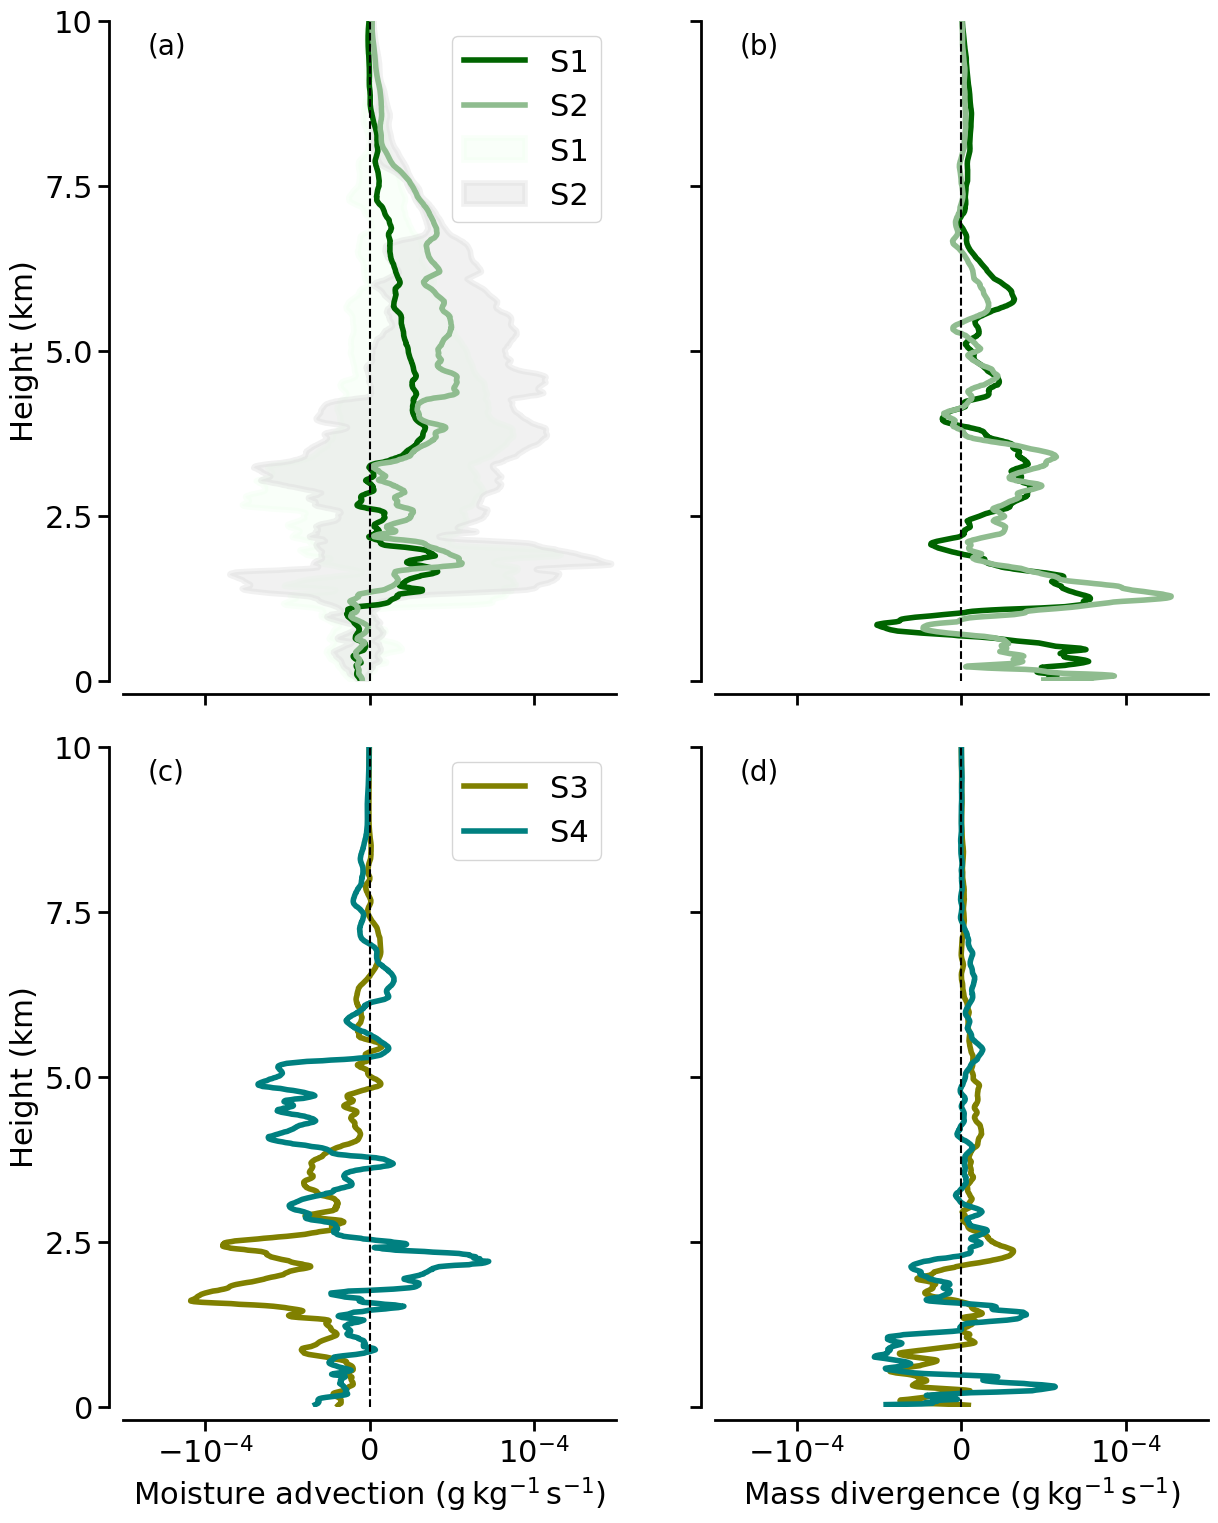

In [20]:
plot_decomposed_divergence_sector_tendency(sector_colors,leg_list,tendency_nabla_ivt,
                                           Dropsondes_dict,unc_sector_colors=unc_sector_colors,with_uncertainties=True)

## Testing

In [10]:
def inflow_outflow_comparison_divergence_components(Dropsondes_dict,relevant_warm_sector_sondes,sector_colors,
                                                    scalar_based_div,
                                                   plot_path=start_path+"/../plots/div_tendency/"):
    matplotlib.rcParams.update({"font.size":16})
    sonde_fig,axs=plt.subplots(nrows=4, ncols=4,figsize=(12,18),sharey=True)
    new_index=np.arange(0,12000,30)

    for l,leg in enumerate(["RF05_AR_entire_1","RF05_AR_entire_2","RF06_AR_entire_1","RF06_AR_entire_2"]):
        relevant_times=[*Dropsondes_dict[leg]["reference_time"].keys()]
        for s,sonde in enumerate([*Dropsondes_dict[leg]["q"].keys()]):
            key=[*Dropsondes_dict[leg]["q"].keys()][s]
            Dropsondes_dict[leg]["transport"]={}
            Dropsondes_dict[leg]["transport"][key]=Dropsondes_dict[leg]["q"][key]*\
                                    Dropsondes_dict[leg]["wspd"][str(relevant_times[s])]
            if s in relevant_warm_sector_sondes[leg+"_in"]:
                q_values  = Dropsondes_dict[leg]["q"][key].values
                z_values  = Dropsondes_dict[leg]["alt"][str(relevant_times[s])]
                v_values  = Dropsondes_dict[leg]["wspd"][str(relevant_times[s])].values
                tra_values= Dropsondes_dict[leg]["transport"][key].values

                q_series=pd.Series(data=q_values,index=z_values)
                q_series.dropna(inplace=True)
                v_series=pd.Series(data=v_values,index=z_values)
                v_series.dropna(inplace=True)
                v_series=v_series[v_series.index.notnull()]
                tra_series=pd.Series(data=tra_values,index=z_values)
                tra_series.dropna(inplace=True)
                leg_type="in"
            
            elif s in relevant_warm_sector_sondes[leg+"_out"]:
                q_values  = Dropsondes_dict[leg]["q"][key].values
                z_values  = Dropsondes_dict[leg]["alt"][str(relevant_times[s])]
                v_values  = Dropsondes_dict[leg]["wspd"][str(relevant_times[s])].values
                tra_values= Dropsondes_dict[leg]["transport"][key].values
                q_series=pd.Series(data=q_values,index=z_values)
                q_series.dropna(inplace=True)
                q_series=q_series[q_series.index.notnull()]
                v_series=pd.Series(data=v_values,index=z_values)
                v_series.dropna(inplace=True)
                v_series=v_series[v_series.index.notnull()]
                tra_series=pd.Series(data=tra_values,index=z_values)
                tra_series.dropna(inplace=True)
                leg_type="out"
            else: 
                continue
            if leg_type=="in":
                line_style="-"

            else:
                line_style="--"
            # Plotting
            axs[l,0].plot(q_series.values*1000,
                            q_series.index/1000,color="lightblue",lw=1,ls=line_style)
            axs[l,1].plot(v_series.values,
                            v_series.index/1000,color="thistle",lw=1,ls=line_style)
            axs[l,2].plot(tra_series.values,tra_series.index/1000,color="grey",lw=1,ls=line_style)


        axs[l,0].plot(interp_vars_df_in[leg]["q"].mean(axis=1).values*1000,new_index/1000,
                      color="darkblue",lw=2,ls="-",label="in")
        axs[l,0].plot(interp_vars_df_out[leg]["q"].mean(axis=1).values*1000,new_index/1000,
                      color="darkblue",lw=2,ls="--",label="out")
        axs[l,1].plot(interp_vars_df_in[leg]["v"].mean(axis=1).values,new_index/1000,
                      color="purple",lw=2,ls="-")
        axs[l,1].plot(interp_vars_df_out[leg]["v"].mean(axis=1).values,new_index/1000,
                      color="purple",lw=2,ls="--")
        axs[l,2].plot(interp_vars_df_in[leg]["tra"].mean(axis=1).values,new_index/1000,
                      color="black",lw=2,ls="-")
        axs[l,2].plot(interp_vars_df_out[leg]["tra"].mean(axis=1).values,new_index/1000,
                      color="black",lw=2,ls="--")
        
        axs[l,3].plot(tendency_nabla_ivt["adv_q"][leg]["val"].values,
                 tendency_nabla_ivt["adv_q"][leg].index/1000,color="darkslateblue",lw=2,label="q_adv")
        axs[l,3].plot(tendency_nabla_ivt["mass_conv"][leg]["val"].values,
                 tendency_nabla_ivt["mass_conv"][leg].index/1000,color="purple",lw=2,label="v_mass")

        axs[l,3].axvline(x=0,ymin=0,ymax=12,ls=":",color="k")
        axs[l,3].set_xlim([-1.5e-4,1.5e-4])
        axs[l,3].set_xticks([-1e-4,0,1e-4])
        axs[l,3].set_xticklabels(["$-1\mathrm{e}^{-4}$","0","$1\mathrm{e}^{-4}$"])
        axs[l,0].set_ylim([0,12])
        axs[l,0].set_xlim([0,5])
        axs[l,0].set_ylabel("Height / km")
        axs[l,1].set_ylim([0,12])
        axs[l,1].set_xlim([10,50])
        axs[l,2].set_ylim([0,12])
        axs[l,2].set_xlim([0,0.15])
        axs[l,3].set_ylim([0,12])
        axs[l,0].text(0.5,11,"S"+str(int(l+1)),color=sector_colors[l],fontsize=14,weight='bold')
        axs[l,0].grid(color="lightgrey")
        axs[l,1].grid(color="lightgrey")
        axs[l,2].grid(color="lightgrey")
        axs[l,3].grid(color="lightgrey")
        if l==0:
            axs[l,0].legend()
            axs[l,3].legend()
        elif l==3:
            axs[l,0].set_xlabel("q / $\mathrm{g\,kg}^{-1}$")
            axs[l,1].set_xlabel("wind / $ \mathrm{m\,s}^{-1}$ ")
            axs[l,2].set_xlabel(" transport / \n $\mathrm{g\,m\,kgs}^{-1}$ ")
            axs[l,3].set_xlabel("divergence / $\mathrm{kg\,s}^{-1}$")
    fig_name="inflow_outflow_divergence"
    if not scalar_based_div:
        fig_name+="_vectorised"
    fig_name+=".png"
    
    sonde_fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as: ",plot_path+fig_name)
    
def plot_didatic_divergence_decomposition(Dropsondes_dict,interp_vars_df_in,interp_vars_df_out,scalar_based_div,
                                         plot_path=start_path+"/../plots/div_tendency/"):
    #matplotlib.rcParams.update({"font.size":16})
    sonde_fig,axs=plt.subplots(nrows=4, ncols=6,figsize=(20,18))
    new_index=np.arange(0,12000,30)

    for l,leg in enumerate(["RF05_AR_entire_1","RF05_AR_entire_2","RF06_AR_entire_1","RF06_AR_entire_2"]):
        domain=pd.DataFrame()
        relevant_times=[*Dropsondes_dict[leg]["reference_time"].keys()]
        print(leg)

        mean_lat=pd.concat([interp_vars_df_in[leg]["lat"],interp_vars_df_out[leg]["lat"]]).mean()
        mean_lon=pd.concat([interp_vars_df_in[leg]["lon"],interp_vars_df_out[leg]["lon"]]).mean()

        domain["Halo_Lat"]=pd.concat([interp_vars_df_in[leg]["lat"],interp_vars_df_out[leg]["lat"]],axis=0)

        domain["Halo_Lon"]=pd.concat([interp_vars_df_in[leg]["lon"],interp_vars_df_out[leg]["lon"]],axis=0)
        domain_values["q"]=pd.concat([interp_vars_df_in[leg]["q"],interp_vars_df_out[leg]["q"]],axis=1)
        domain_values["u"]=pd.concat([interp_vars_df_in[leg]["u"],interp_vars_df_out[leg]["u"]],axis=1)
        domain_values["v"]=pd.concat([interp_vars_df_in[leg]["v"],interp_vars_df_out[leg]["v"]],axis=1)

        geo_domain=moist_conv.get_xy_coords_for_domain(domain)

        q_mean,q_dx,q_dy=moist_conv.run_haloac3_sondes_regression(geo_domain,domain_values,"q",
                                      with_uncertainty=False,regression_method="least-squared")
        u_mean,u_dx,u_dy=moist_conv.run_haloac3_sondes_regression(geo_domain,domain_values,"u",
                                      with_uncertainty=False,regression_method="least-squared")
        v_mean,v_dx,v_dy=moist_conv.run_haloac3_sondes_regression(geo_domain,domain_values,"v",
                                      with_uncertainty=False,regression_method="least-squared")

        axs[l,0].scatter(interp_vars_df_in[leg]["lon"],
                             interp_vars_df_in[leg]["lat"],
                             c=interp_vars_df_in[leg]["q"].loc[0:4000].mean(axis=0)*1000,
                             s=100,vmin=1.0,vmax=4.0,
                             cmap=plt.get_cmap("Blues"),marker="^",edgecolor="k",lw=1)
        axs[l,0].scatter(interp_vars_df_out[leg]["lon"],
                             interp_vars_df_out[leg]["lat"],
                             c=interp_vars_df_out[leg]["q"].loc[0:4000].mean(axis=0)*1000,
                             s=100,
                             cmap=plt.get_cmap("Blues"),vmin=1.0,vmax=4.0,marker="s",edgecolor="k",lw=1)
        axs[l,0].quiver(interp_vars_df_in[leg]["lon"],#x
                        interp_vars_df_in[leg]["lat"],#y
                        interp_vars_df_in[leg]["u"].loc[0:4000].mean(axis=0),#u
                        interp_vars_df_in[leg]["v"].loc[0:4000].mean(axis=0),#v
                       scale=100)
        axs[l,0].quiver(interp_vars_df_out[leg]["lon"],#x
                        interp_vars_df_out[leg]["lat"],#y
                        interp_vars_df_out[leg]["u"].loc[0:4000].mean(axis=0),#u
                        interp_vars_df_out[leg]["v"].loc[0:4000].mean(axis=0),#v
                       scale=100)

        combined_q_mean_low=pd.concat([interp_vars_df_in[leg]["q"].loc[0:4000].mean(axis=0),
                                     interp_vars_df_out[leg]["q"].loc[0:4000].mean(axis=0)],axis=0)
        combined_u_mean_low=pd.concat([interp_vars_df_in[leg]["u"].loc[0:4000].mean(axis=0),
                                     interp_vars_df_out[leg]["u"].loc[0:4000].mean(axis=0)],axis=0)
        combined_v_mean_low=pd.concat([interp_vars_df_in[leg]["v"].loc[0:4000].mean(axis=0),
                                     interp_vars_df_out[leg]["v"].loc[0:4000].mean(axis=0)],axis=0)

        #axs[l,0].text(mean_lon,mean_lat,"Mean \n value \n to be placed",fontsize=10)
        if l==1:
            axs[l,0].set_ylabel("Latitude deg N")
        elif l==3:
            axs[l,0].set_xlabel("Longitude deg E")

        axs[l,1].scatter(geo_domain["dx"]/1000,geo_domain["dy"]/1000,
                         c=combined_q_mean_low.values*1000,s=100,
                         cmap=plt.get_cmap("Blues"),vmin=1.0,vmax=4.0,marker="o",edgecolor="k",lw=1)

        axs[l,1].quiver(0,0,q_dx.loc[0:4000].mean(axis=0)*1000*1000,0,scale=0.01)
        axs[l,1].quiver(0,0,0,q_dy.loc[0:4000].mean(axis=0)*1000*1000,scale=0.01)
        axs[l,1].text(0.02,0.55,"dq/dx="+str(round(q_dx.loc[0:4000].mean(axis=0)*1000*1000,3))+"g/km",fontsize=8,
                     transform=axs[l,1].transAxes)
        axs[l,1].text(0.55,0.65,"dq/dy="+str(round(q_dy.loc[0:4000].mean(axis=0)*1000*1000,3))+"g/km",fontsize=8,
                     transform=axs[l,1].transAxes)

        #axs[l,2].quiver(geo_domain["dx"]/1000,geo_domain["dy"]/1000,u_dx.loc[0:4000].mean(axis=0)*1000*1000,0,scale=0.01)

        axs[l,1].quiver(0,0,0,q_dy.loc[0:4000].mean(axis=0)*1000*1000,scale=0.01)

        #axs[l,1].text(0.02,0.55,"dq/dx="+str(round(q_dx.loc[0:4000].mean(axis=0)*1000*1000,3))+"g/km",fontsize=8,
        #             transform=axs[l,1].transAxes)
        #axs[l,1].text(0.55,0.65,"dq/dy="+str(round(q_dy.loc[0:4000].mean(axis=0)*1000*1000,3))+"g/km",fontsize=8,
        #             transform=axs[l,1].transAxes)
        axs[l,1].set_ylabel(" Distance / km",labelpad=-15,fontsize=9)
        # u wind
        axs[l,2].scatter(geo_domain["dx"]/1000,geo_domain["dy"]/1000,
                         c=combined_u_mean_low.values,s=100,
                         cmap=plt.get_cmap("Purples"),vmin=2.0,vmax=25.0,marker=">",edgecolor="k",lw=1)
        axs[l,2].quiver(0,0,u_dx.loc[0:4000].mean(axis=0)*1000,0,scale=0.05)
        axs[l,2].quiver(0,0,0,u_dy.loc[0:4000].mean(axis=0)*1000,scale=.05)
        axs[l,2].text(0.02,0.55,"du/dx="+str(round(u_dx.loc[0:4000].mean(axis=0)*1000,3))+"m/s.1/km",fontsize=8,
                     transform=axs[l,2].transAxes)
        axs[l,2].text(0.55,0.65,"du/dy="+str(round(u_dy.loc[0:4000].mean(axis=0)*1000,3))+"m/s.1/km",fontsize=8,
                     transform=axs[l,2].transAxes)
        # v wind
        axs[l,3].scatter(geo_domain["dx"]/1000,geo_domain["dy"]/1000,
                         c=combined_v_mean_low.values,s=100,
                         cmap=plt.get_cmap("Purples"),vmin=2.0,vmax=25.0,marker="^",edgecolor="k",lw=1)
        axs[l,3].quiver(0,0,v_dx.loc[0:4000].mean(axis=0)*1000,0,scale=0.05)
        axs[l,3].quiver(0,0,0,v_dy.loc[0:4000].mean(axis=0)*1000,scale=.05)
        axs[l,3].text(0.02,0.55,"dv/dx="+str(round(v_dx.loc[0:4000].mean(axis=0)*1000,3))+"m/s.1/km",fontsize=8,
                     transform=axs[l,3].transAxes)
        axs[l,3].text(0.55,0.65,"dv/dy="+str(round(v_dy.loc[0:4000].mean(axis=0)*1000,3))+"m/s.1/km",fontsize=8,
                     transform=axs[l,3].transAxes)
        if l< 3:
            axs[l,2].set_yticklabels("")
            axs[l,3].set_yticklabels("")
            axs[l,2].set_xticklabels("")
            axs[l,3].set_xticklabels("")
        axs[l,4].plot([0,combined_u_mean_low.mean(axis=0)*q_dx.loc[0:4000].mean(axis=0)*1000],[0,0],lw=3)
        axs[l,4].plot([0,0],[0,combined_v_mean_low.mean(axis=0)*q_dy.loc[0:4000].mean(axis=0)*1000],lw=3)
        axs[l,5].plot([0,combined_q_mean_low.mean(axis=0)*u_dx.loc[0:4000].mean(axis=0)*1000],[0,0],lw=3)
        axs[l,5].plot([0,0],[0,combined_q_mean_low.mean(axis=0)*v_dy.loc[0:4000].mean(axis=0)*1000],lw=3)
        axs[l,4].set_xlim([-1e-4,1e-4])
        axs[l,4].set_ylim([-1e-4,1e-4])
        axs[l,4].set_xticks([-1e-4,0,1e-4])
        axs[l,4].set_yticks([-1e-4,0,1e-4])
        axs[l,4].set_xticklabels(["-1e-4","0","1e-4"])
        axs[l,4].set_yticklabels(["-1e-4","0","1e-4"])
        axs[l,5].set_xlim([-1e-4,1e-4])
        axs[l,5].set_ylim([-1e-4,1e-4])
        axs[l,5].set_xticks([-1e-4,0,1e-4])
        axs[l,5].set_yticks([-1e-4,0,1e-4])
        axs[l,5].set_yticklabels([])
        axs[l,5].set_xticklabels(["-1e-4","0","1e-4"])

        axs[0,0].set_title("q and $\\vec v$")
        axs[0,1].set_title("grad q")
        axs[0,2].set_title("grad u")
        axs[0,3].set_title("grad v")
        axs[0,4].set_title("moist advection \n (grad q $\\cdot\\vec v$)",fontsize=11)
        axs[0,5].set_title("mass divergence \n ($\\overline{q} \\cdot \\vec v$)",fontsize=11)
        ##axs[l,4].scatter(geo_domain["dx"]/1000,geo_domain["dy"]/1000,
        #                 c=combined_v_mean_low.values,s=100,
        #                 cmap=plt.get_cmap("Purples"),vmin=2.0,vmax=10.0,marker="^",edgecolor="k",lw=1)
        sns.despine(ax=axs[l,0],offset=5)
        sns.despine(ax=axs[l,1],offset=5)#axs[l,0].scatter(interp_vars_df_out[leg]["lon"],
        sns.despine(ax=axs[l,2],offset=5)
        sns.despine(ax=axs[l,3],offset=5)
        sns.despine(ax=axs[l,4],offset=5)
        sns.despine(ax=axs[l,5],offset=5)

    plt.subplots_adjust(hspace=0.2,wspace=.2)
    fig_name="Didacted_Decomposition_Sectors_Divergence"
    if not scalar_based_div:
        fig_name+="_vectorised"
    fig_name+=".png"
    sonde_fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)

In [ ]:


#plot_combined_divergence_sector_tendency(tendency_nabla_ivt,sector_colors,scalar_based_div)

In [ ]:
#inflow_outflow_comparison_divergence_components(Dropsondes_dict,relevant_warm_sector_sondes,sector_colors,scalar_based_div)

In [ ]:
import moisturebudget

moist_conv=moisturebudget.Moisture_Convergence
domain_values={}
#q_dx.loc[0:4000].mean()
#nonnan_values=domain_values["q"]#.dropna(axis=0,how='any').T
#domain_values["q"].to_csv(path_or_buf=os.getcwd()+"test_q.csv")        

RF05_AR_entire_1
domain ready for regression
Perform divergence via regression method: least-squared
Perform divergence via regression method: least-squared
Perform divergence via regression method: least-squared
RF05_AR_entire_2
domain ready for regression
Perform divergence via regression method: least-squared
Perform divergence via regression method: least-squared
Perform divergence via regression method: least-squared
RF06_AR_entire_1
domain ready for regression
Perform divergence via regression method: least-squared
Perform divergence via regression method: least-squared
Perform divergence via regression method: least-squared
RF06_AR_entire_2
domain ready for regression
Perform divergence via regression method: least-squared
Perform divergence via regression method: least-squared
Perform divergence via regression method: least-squared
Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/div_tendency/Didac

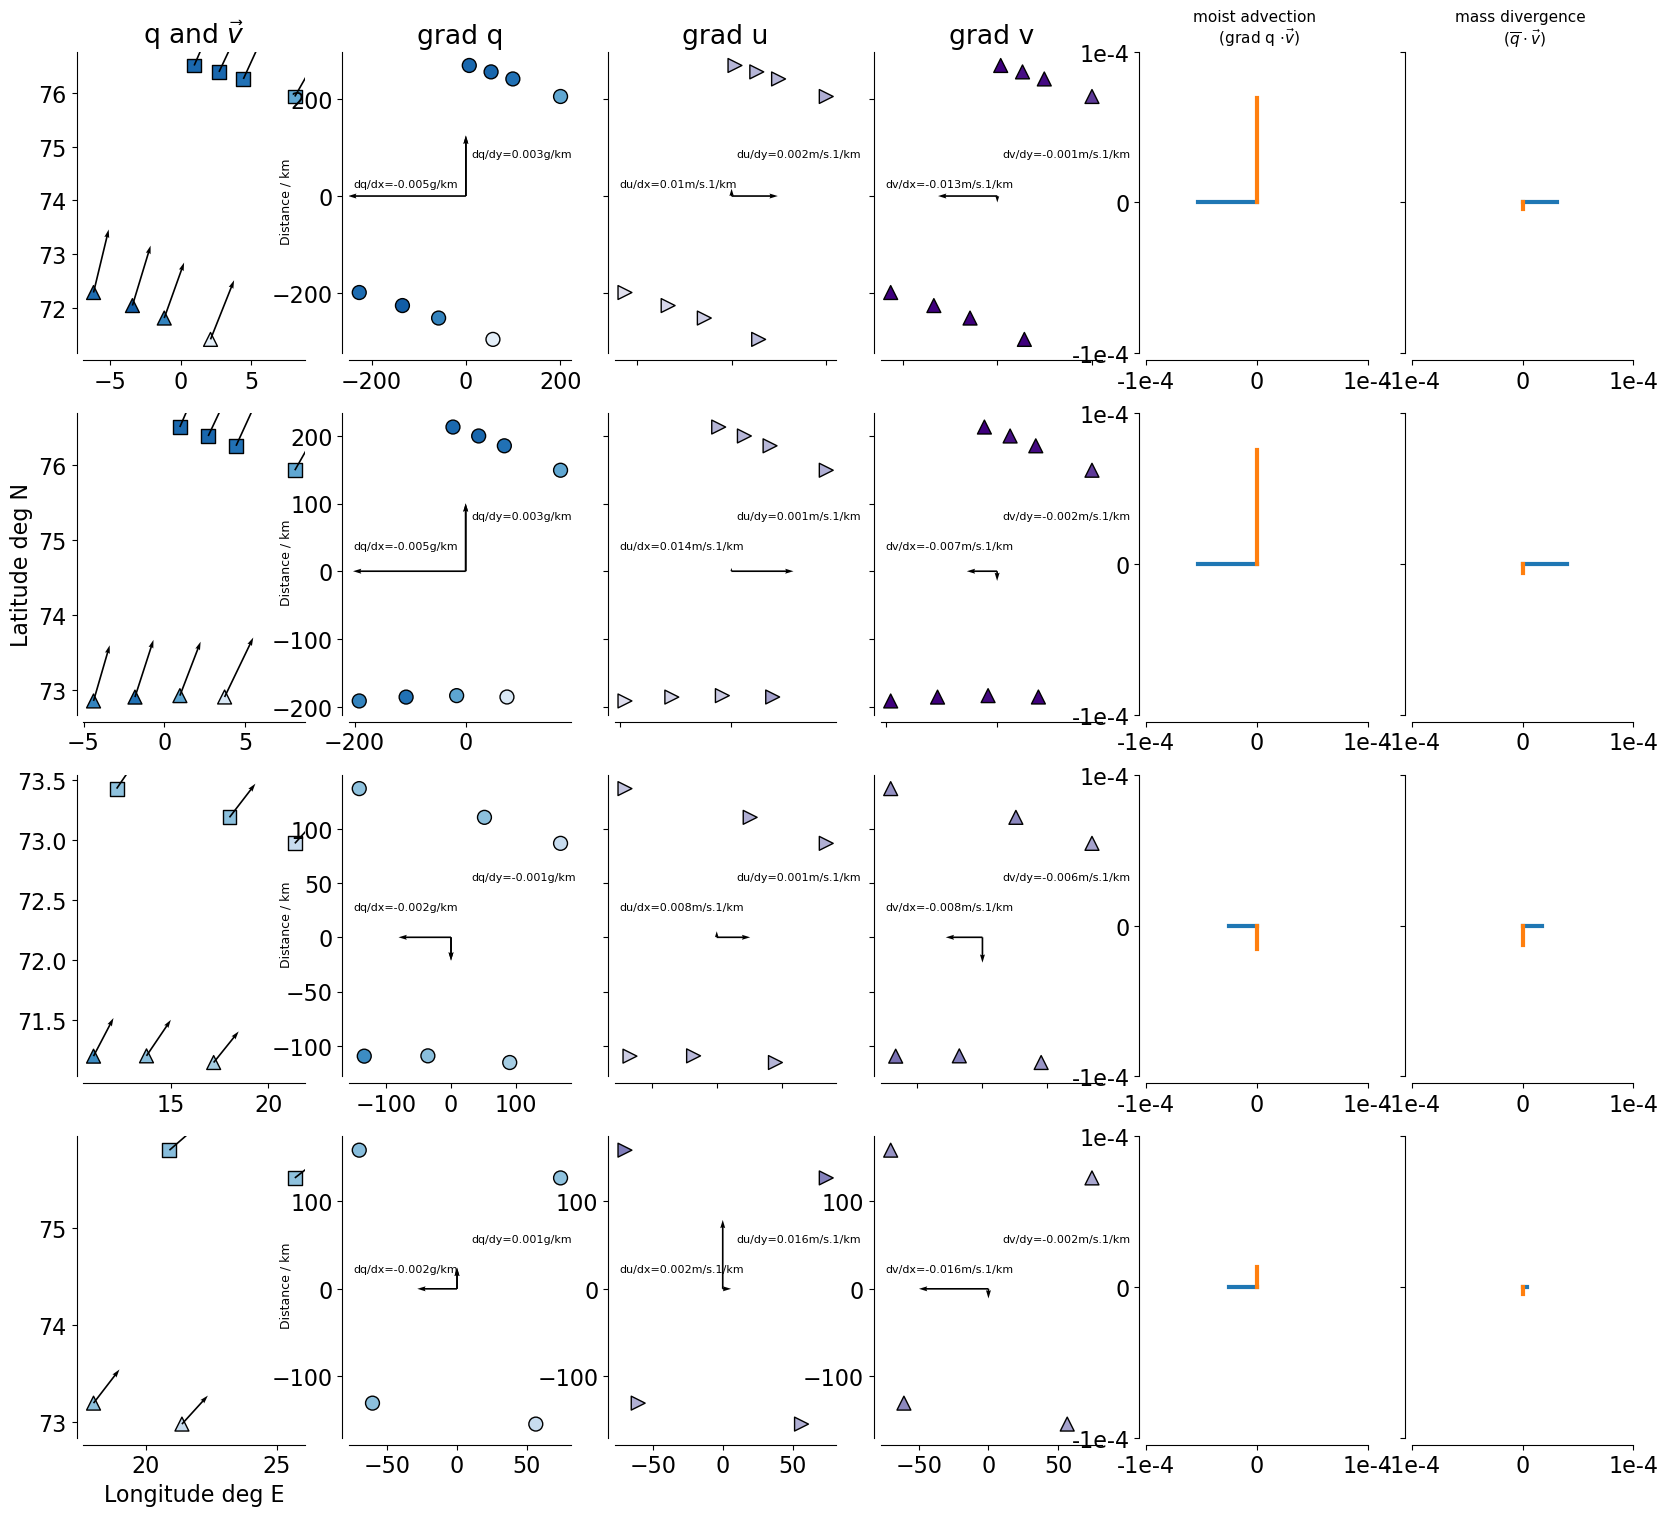

In [13]:
plot_didatic_divergence_decomposition(Dropsondes_dict,interp_vars_df_in,interp_vars_df_out,scalar_based_div)